<a href="https://colab.research.google.com/github/gpapadok/gan-variations/blob/master/wasserstein_conditional_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [0]:
# set parameters
LR = .00005
EPOCHS = 1
# BETA1 = .5
BATCH_SIZE = 64

# wasserstein parameters
WEIGHT_CLIP = .05
DISC_ITER = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# open in google colab

import pandas as pd
from torch.utils.data import Dataset

class MNIST(Dataset):
  def __init__(self, train_csv, test_csv, transform=None):
    self.trainset = pd.read_csv(train_csv)
    self.testset = pd.read_csv(test_csv)
    self.transform = transform

  def __getitem__(self, idx):
    if idx <= 19998:
      sample = self.trainset.iloc[idx, 1:].values
      label = self.trainset.iloc[idx,0]
    else:
      idx -= 19999
      sample = self.testset.iloc[idx, 1:].values
      label = self.testset.iloc[idx,0]

    sample = sample.reshape(28, 28).astype('float32')
    if self.transform:
      sample = self.transform(sample)

    return sample, label.reshape(1)

  def __len__(self):
    return len(self.trainset) + len(self.testset)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.,), (1.,))
     ])

trainset = MNIST('sample_data/mnist_train_small.csv', 'sample_data/mnist_test.csv', transform)

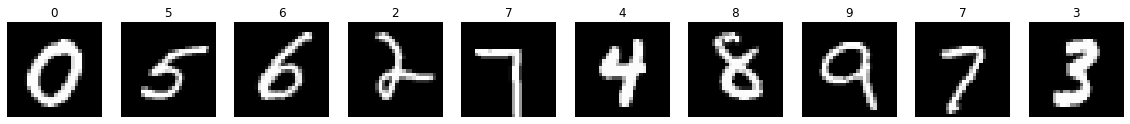

In [88]:
# PLOT 10 RANDOM DIGITS
def plot_digits(dataset):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
  trainiter = iter(trainloader)
  batch = trainiter.next()

  fig = plt.figure(figsize=(20,200))
  for j in range(10):
    plt.subplot(1,10,j+1)
    plt.imshow(batch[0][j][0,:], cmap='gray')
    plt.title(batch[1][j].item())
    plt.axis('off')

plot_digits(trainset)

In [0]:
# GENERATOR AND DISCRIMINATOR MODELS
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.embedding = nn.Embedding(10, 10)

    self.conv1 = nn.ConvTranspose2d(100+10, 512, 5)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv2 = nn.ConvTranspose2d(512, 128, 4)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.ConvTranspose2d(128, 64, 4)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.ConvTranspose2d(64, 32, 5, 2)
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.ConvTranspose2d(32, 1, 4)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input, labels):
    labels = self.embedding(labels).view(-1, 10)
    x = torch.cat([input, labels], dim=1)
    x = x.view(-1, 100+10, 1, 1)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.leaky_relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.leaky_relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.leaky_relu(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.leaky_relu(x)
    x = self.conv5(x)

    return torch.tanh(x)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.embedding = nn.Embedding(10, 10)

    self.conv1 = nn.Conv2d(1, 32, 5)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32+10, 64, 4)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 4)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, 5, 2)
    self.bn4 = nn.BatchNorm2d(256)
    self.fc = nn.Linear(256 * 7 * 7, 1)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input, labels):
    labels = self.embedding(labels).view(-1, 10, 1, 1)

    x = self.conv1(input)
    x = self.bn1(x)
    x = self.leaky_relu(x)

    _, _, x_dim, y_dim = x.size()
    labels_layer = labels.expand(-1, 10, x_dim, y_dim)
    x = torch.cat([x, labels_layer], dim=1)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.leaky_relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.leaky_relu(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.leaky_relu(x)
    x = self.fc(x.view(-1, 256 * 7 * 7))
    return x

In [0]:
# GAN MODEL
class WGAN():
  def __init__(self, generator, discriminator, loss, optimizerG, optimizerD, batch_size=BATCH_SIZE):
    self.generator = generator
    self.discriminator = discriminator
    self.loss = loss
    self.optimG = optimizerG
    self.optimD = optimizerD
    self.batch_size = batch_size

  def generate_fake(self, batch, labels):
    return self.generator(batch, labels)

  def plot_ten_samples(self):
    noise = torch.randn(10, 100, device=device)
    labels = torch.tensor([0,1,2,3,4,5,6,7,8,9], device=device)
    fake = self.generate_fake(noise, labels).cpu()
    fake = fake.detach().numpy()

    fig = plt.figure(figsize=(20,200))
    for j in range(10):
      plt.subplot(1,10,j+1)
      plt.imshow(fake[j][0], cmap='gray')
      plt.axis('off')
    plt.show()

  def train(self, trainset, epochs=EPOCHS, verbose=True):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)

    errG_history = []
    errD_real_history = []
    errD_fake_history = []
    try:
      for epoch in range(epochs):

        errg_ = []
        errd_real_ = []
        errd_fake_ = []

        self.plot_ten_samples()
        for j, data in enumerate(trainloader, 0):
          # TRAIN DISCRIMINATOR
          self.optimD.zero_grad()

          # Train with real
          real = data[0].to(device)
          real_target = data[1].to(device)
          batch_size = real.size()[0]
          out = self.discriminator(real, real_target)
          errD_real = - out.mean()
          errD_real.backward()


          # Train with fake
          noise = torch.randn(batch_size, 100, device=device)
          fake = self.generate_fake(noise, real_target)
          out = self.discriminator(fake, real_target)
          errD_fake = out.mean()
          errD_fake.backward()

          self.optimD.step()

          errd_real_ += [- errD_real.item()]
          errd_fake_ += [errD_fake.item()]

          # weight clipping
          for p in self.discriminator.parameters():
              p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

          # TRAIN GENERATOR
          if j % DISC_ITER == 0:
            self.optimG.zero_grad()

            noise = torch.randn(batch_size, 100, device=device)
            fake_target = torch.randint(0, 10, (batch_size,), device=device)
            fake = self.generate_fake(noise, fake_target)
            out = self.discriminator(fake, fake_target)
            errG = - out.mean()
            errG.backward()

            self.optimG.step()

            errg_ += [errG.item()]

        errD_real_history.append(torch.tensor(errd_real_).mean().item())
        errD_fake_history.append(torch.tensor(errd_fake_).mean().item())
        errG_history.append(torch.tensor(errg_).mean().item())
        print(f'EPOCH {epoch+1:2}/{epochs} | ', end='')
        print(f'disc_real_loss: {errD_real_history[-1]:.4f} - disc_fake_loss: {errD_fake_history[-1]:.4f} - gen_loss: {errG_history[-1]:.4f}')
    except:
      import traceback
      traceback.print_exc()
    finally:
      return errG_history, errD_real_history, errD_fake_history
      

In [0]:
# CREATE NETS
dnet = Discriminator().to(device)
gnet = Generator().to(device)

# print(gnet)
# print(dnet)

In [0]:
# ADD LOSS FUNCTION AND OPTIMIZERS

optimizerD = optim.RMSprop(dnet.parameters(), lr=LR)
optimizerG = optim.RMSprop(gnet.parameters(), lr=LR)


gan = WGAN(gnet, dnet, None, optimizerG, optimizerD)

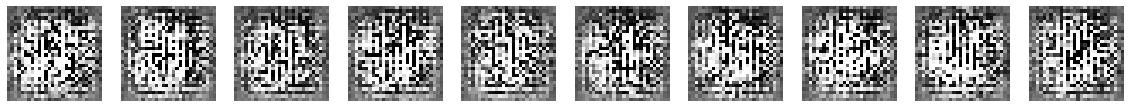

EPOCH  1/20 | disc_real_loss: 1.0229 - disc_fake_loss: -1.4192 - gen_loss: 1.5184


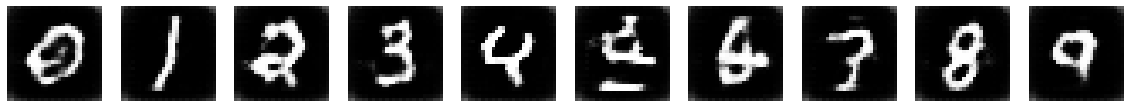

EPOCH  2/20 | disc_real_loss: 2.0215 - disc_fake_loss: -5.6682 - gen_loss: 5.8772


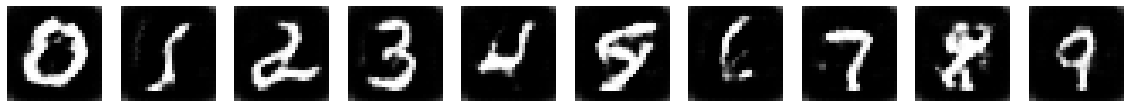

EPOCH  3/20 | disc_real_loss: 3.2817 - disc_fake_loss: -8.8428 - gen_loss: 9.2443


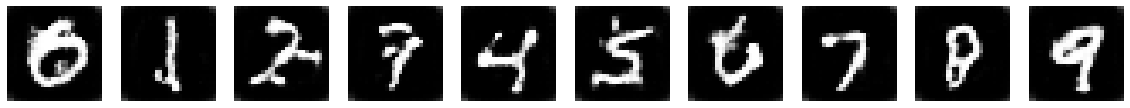

EPOCH  4/20 | disc_real_loss: 5.2707 - disc_fake_loss: -10.4134 - gen_loss: 10.9307


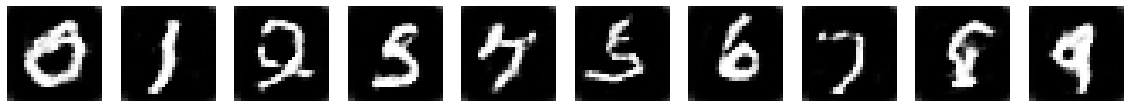

EPOCH  5/20 | disc_real_loss: 5.4513 - disc_fake_loss: -10.6443 - gen_loss: 11.3424


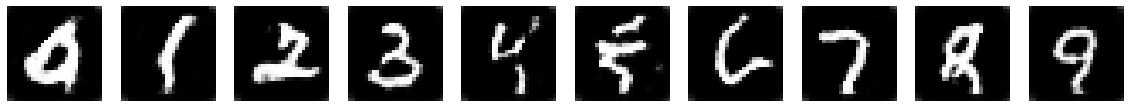

EPOCH  6/20 | disc_real_loss: 5.5181 - disc_fake_loss: -10.1786 - gen_loss: 10.8085


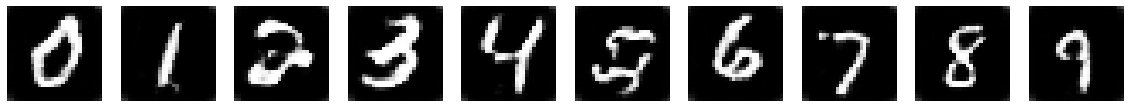

EPOCH  7/20 | disc_real_loss: 4.0266 - disc_fake_loss: -9.5896 - gen_loss: 10.1496


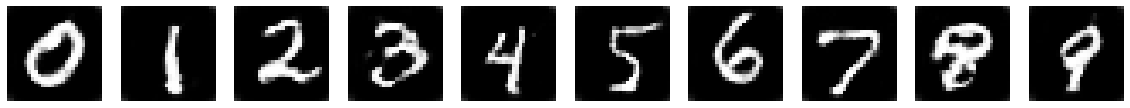

EPOCH  8/20 | disc_real_loss: 3.1742 - disc_fake_loss: -7.4782 - gen_loss: 8.1118


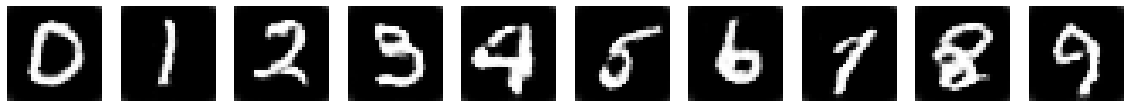

EPOCH  9/20 | disc_real_loss: 3.0542 - disc_fake_loss: -7.3123 - gen_loss: 7.7611


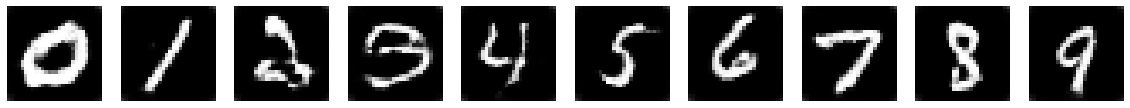

EPOCH 10/20 | disc_real_loss: 2.9236 - disc_fake_loss: -7.9287 - gen_loss: 7.9492


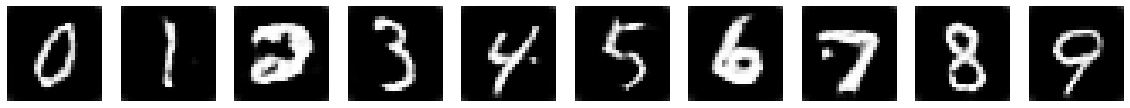

EPOCH 11/20 | disc_real_loss: 3.2278 - disc_fake_loss: -7.2983 - gen_loss: 7.7885


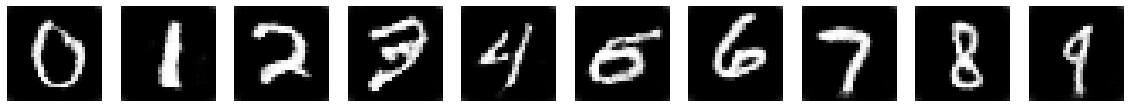

EPOCH 12/20 | disc_real_loss: 2.4575 - disc_fake_loss: -7.0507 - gen_loss: 7.6316


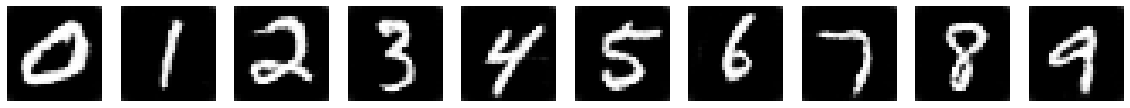

EPOCH 13/20 | disc_real_loss: 2.8050 - disc_fake_loss: -6.9822 - gen_loss: 7.3784


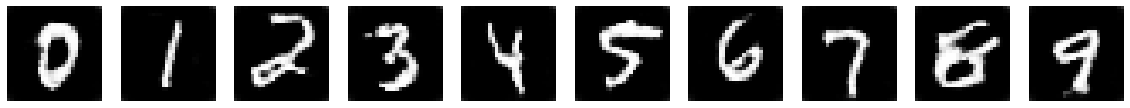

EPOCH 14/20 | disc_real_loss: 2.6435 - disc_fake_loss: -6.8411 - gen_loss: 7.3452


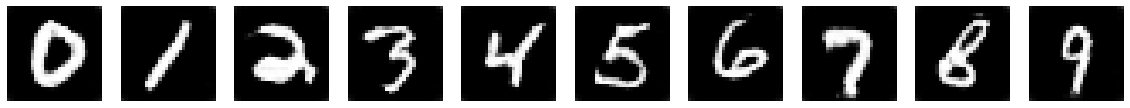

EPOCH 15/20 | disc_real_loss: 2.5848 - disc_fake_loss: -6.7657 - gen_loss: 7.3571


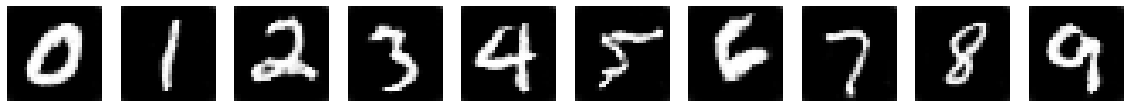

EPOCH 16/20 | disc_real_loss: 2.5031 - disc_fake_loss: -6.4763 - gen_loss: 6.9131


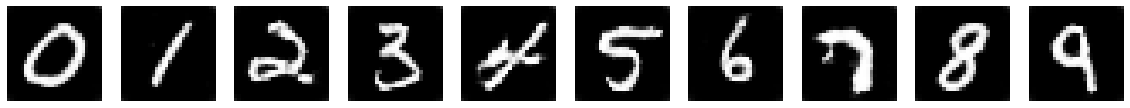

EPOCH 17/20 | disc_real_loss: 2.6046 - disc_fake_loss: -6.2297 - gen_loss: 6.6759


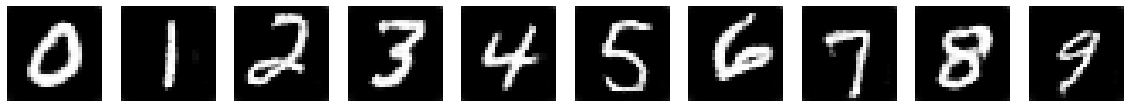

EPOCH 18/20 | disc_real_loss: 2.7514 - disc_fake_loss: -5.9629 - gen_loss: 6.5590


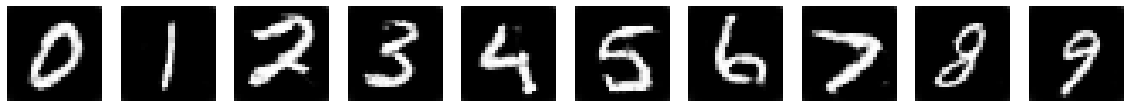

EPOCH 19/20 | disc_real_loss: 2.4250 - disc_fake_loss: -6.2183 - gen_loss: 6.8295


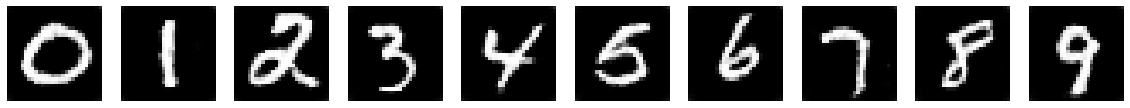

EPOCH 20/20 | disc_real_loss: 2.6733 - disc_fake_loss: -5.8642 - gen_loss: 6.3832


In [93]:
# TRAIN
errorG_history, errorD_real_history, errorD_fake_history = gan.train(trainset, epochs=20)

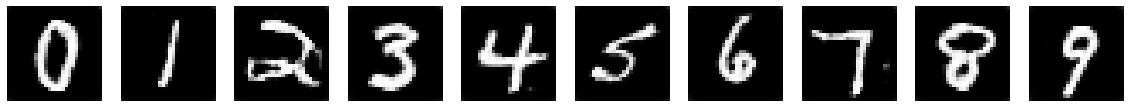

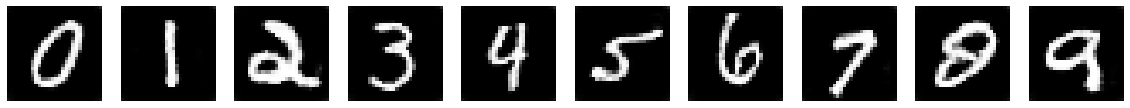

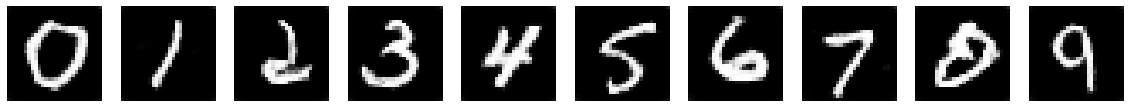

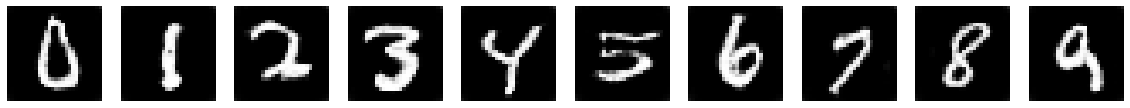

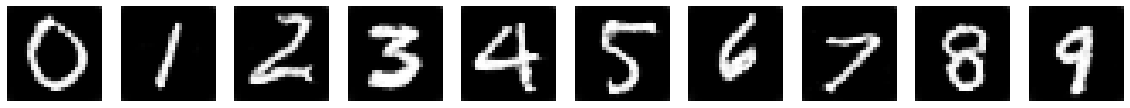

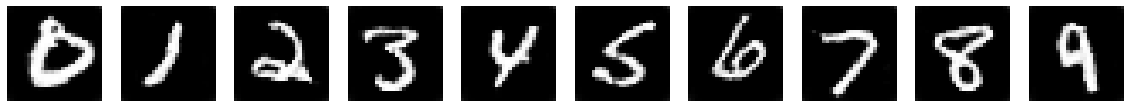

In [94]:
# PLOT TEN GENERATED DIGITS
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()

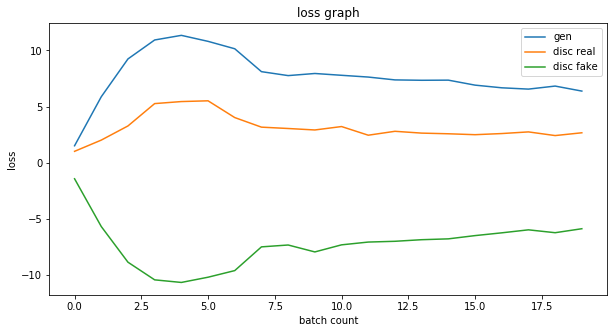

In [95]:
# PLOT GENERATOR AND DISCRIMINATOR ERRORS
plt.figure(figsize=(10,5))
plt.plot(errorG_history)
plt.plot(errorD_real_history)
plt.plot(errorD_fake_history)
plt.title('loss graph')
plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(['gen','disc real', 'disc fake'])
plt.show()